In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV
try:
    df = pd.read_csv('kigali_traffic_dataset.csv', delimiter=',', engine='python')
    print("Dataset loaded successfully. First few rows:")
    print(df.head())
except pd.errors.ParserError as e:
    print("ParserError:", e)
    raise Exception("Check CSV for formatting issues (e.g., missing commas, incomplete rows).")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values (if any)
for col in ['Day_of_Week', 'Public_Holiday', 'Road_Name', 'Population_Density', 'Rainfall', 'Congestion_Level']:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

# Drop unwanted columns
df = df.drop(['Average_Speed', 'Proximity_to_POI'], axis=1)

# Convert Time to Hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
df = df.drop('Time', axis=1)

# Encode categorical variables
categorical_cols = ['Day_of_Week', 'Public_Holiday', 'Road_Name', 'Population_Density', 'Rainfall']
le_dict = {}
for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    df[col] = df[col].astype(str)  # Convert to string to handle any None
    df[col] = le_dict[col].fit_transform(df[col])

# Encode target variable
le_dict['Congestion_Level'] = LabelEncoder()
df['Congestion_Level'] = le_dict['Congestion_Level'].fit_transform(df['Congestion_Level'])

# Split features and target
X = df.drop('Congestion_Level', axis=1)
y = df['Congestion_Level']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset loaded successfully. First few rows:
    Time Day_of_Week Public_Holiday  Road_Name Proximity_to_POI Average_Speed  \
0  00:00   Wednesday            Yes    KN 1 Rd         Bus Park          40.5   
1  01:00   Wednesday            Yes  KG 11 Ave           Market          42.3   
2  08:00   Wednesday            Yes   KK 15 Rd           School          24.8   
3  09:00   Wednesday            Yes        RN1       Commercial          28.2   
4  17:00   Wednesday            Yes    KN 3 Rd           School          20.7   

  Population_Density Rainfall Congestion_Level  
0               High       No              Low  
1             Medium       No              Low  
2             Medium      Yes             High  
3               High       No           Medium  
4             Medium       No             High  
Missing values per column:
Time                  0
Day_of_Week           0
Public_Holiday        0
Road_Name             0
Proximity_to_POI      0
Average_Speed         0
Pop

/tmp/ipython-input-2-2660593875.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [4]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Convert numerical labels to strings for classification report
y_test_str = le_dict['Congestion_Level'].inverse_transform(y_test)
y_pred_str = le_dict['Congestion_Level'].inverse_transform(y_pred)
print("Classification Report:")
print(classification_report(y_test_str, y_pred_str, target_names=le_dict['Congestion_Level'].classes_))

Accuracy: 0.9777777777777777
Classification Report:
              precision    recall  f1-score   support

        High       0.98      0.96      0.97        52
         Low       1.00      1.00      1.00        11
      Medium       0.97      0.99      0.98        72

    accuracy                           0.98       135
   macro avg       0.98      0.98      0.98       135
weighted avg       0.98      0.98      0.98       135



In [7]:
# Create user input
user_input = pd.DataFrame({
    'Hour': [2],  # 02:15 AM rounds to 2
    'Day_of_Week': ['Monday'],
    'Public_Holiday': ['No'],
    'Road_Name': ['KN 1 Rd'],
    'Population_Density': ['High'],
    'Rainfall': ['No']
})

# Encode user input
categorical_cols_input = ['Day_of_Week', 'Public_Holiday', 'Road_Name', 'Population_Density', 'Rainfall']
for col in categorical_cols_input:
    user_input[col] = user_input[col].astype(str)
    # Ensure input values are valid
    if not all(user_input[col].isin(le_dict[col].classes_)):
        raise ValueError(f"Invalid value in {col}. Must be one of {le_dict[col].classes_}")
    user_input[col] = le_dict[col].transform(user_input[col])

# Reorder columns to match the training data
user_input = user_input[X_train.columns]

# Predict
prediction = model.predict(user_input)
predicted_congestion = le_dict['Congestion_Level'].inverse_transform(prediction)[0]
print("Predicted Congestion Level:", predicted_congestion)

Predicted Congestion Level: Low


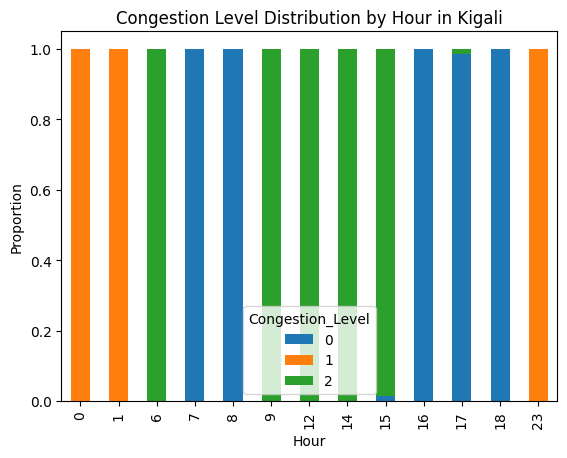

In [8]:
import matplotlib.pyplot as plt
df.groupby('Hour')['Congestion_Level'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title('Congestion Level Distribution by Hour in Kigali')
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.show()

In [10]:
# Save the model and encoders
import joblib

joblib.dump(model, 'traffic_model.pkl')
joblib.dump(le_dict, 'label_encoders.pkl')
print("Model and encoders saved as 'traffic_model.pkl' and 'label_encoders.pkl'")

Model and encoders saved as 'traffic_model.pkl' and 'label_encoders.pkl'
